# Compute  PCA : Method 1 for Bruzual Charlot

- use PCA scikit learn from scikit learn

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date : 2023/01/08
- last update : 2023/01/20

In [1]:
# Import some generally useful packages

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline
import pandas as pd
from itertools import cycle, islice

from astroML.utils.decorators import pickle_results


In [2]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)


In [3]:
from sklearn.decomposition import NMF, FastICA, PCA

In [4]:
from astropy.io import fits

## Start

In [5]:
cwd=os.path.abspath("")
main_dir = cwd
print(f"notebook current executing path : {cwd}")

notebook current executing path : /Users/sylvie/MacOSX/GitHub/LSST/PhotoZ_PhD/PCA


## Read file

In [6]:
filename = 'datatools/pca_BruzualCharlot_data.fits'
hdu = fits.open(filename)
data_in=hdu[0].data
hdr_in = hdu[0].header

In [7]:
data_in

array([[0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        9.99800000e+03, 9.99900000e+03, 1.00000000e+04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.80629979e-05, 3.80474041e-05, 3.80318102e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        5.46250276e-05, 5.45989758e-05, 5.45729276e-05],
       ...,
       [8.00000000e+01, 0.00000000e+00, 0.00000000e+00, ...,
        1.50613145e-05, 1.50546443e-05, 1.50479742e-05],
       [8.10000000e+01, 0.00000000e+00, 0.00000000e+00, ...,
        3.44111866e-05, 3.43962957e-05, 3.43814048e-05],
       [8.20000000e+01, 0.00000000e+00, 0.00000000e+00, ...,
        1.91040033e-06, 1.90872255e-06, 1.90704476e-06]])

In [8]:
NSED = data_in.shape[0]-3
NWL = data_in.shape[1]-1

In [9]:
wavelengths = data_in[0,1:] 
flambdas_average = data_in[1,1:] 
flambdas_std = data_in[2,1:] 
spec = data_in[3:,1:] 
all_numbers = data_in[3:,0] 

In [10]:
#flux = dfluxnorm*flambdas_std +  flambdas_average

/var/folders/m7/6pm3rhtj0c71ls7jj9mn1g740000gp/T/ipykernel_43227/1659706449.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:.0f}'.format(x) for x in current_values])


Text(0.5, 1.0, 'Flux average')

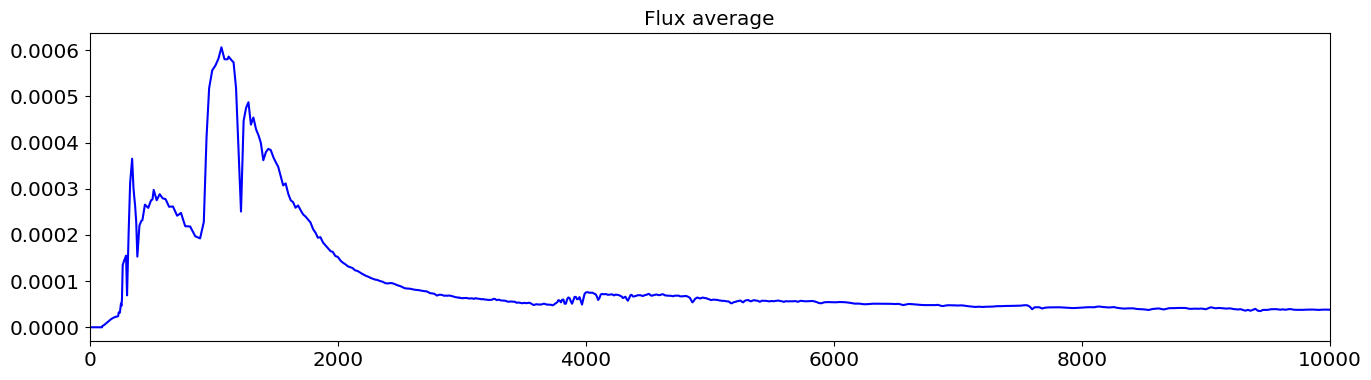

In [11]:
plt.figure(figsize=(16,4))
plt.plot(wavelengths,flambdas_average,'b-')
plt.xlim(0.,10000.)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:.0f}'.format(x) for x in current_values])
plt.title("Flux average")

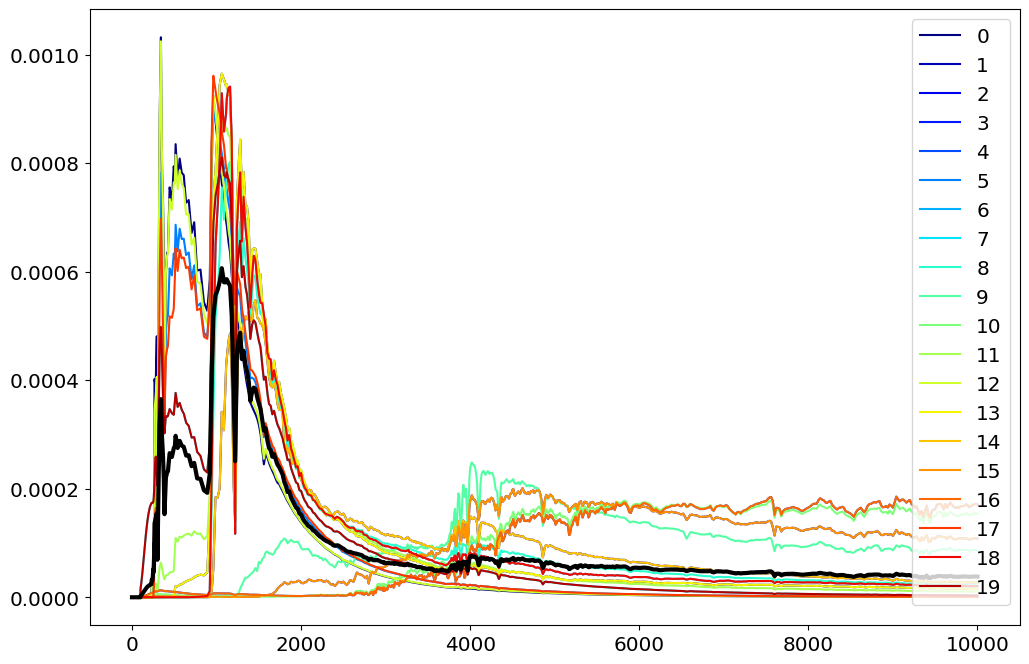

In [12]:
# wavelength bin colors
NTOPLOT=20
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NTOPLOT)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NTOPLOT), alpha=1)


fig = plt.figure(figsize=(12, 8))

for idx in np.arange(20):
    plt.plot(wavelengths,spec[idx,:],color=all_colors[idx],label=str(idx))

plt.legend()
spec_mean = spec.mean(0)
plt.plot(wavelengths,spec_mean,"k-",lw=3)
#plt.ylim(0,50.)

## Principal Component Analysis


https://www.astroml.org/astroML-notebooks/chapter7/astroml_chapter7_Dimensionality_Reduction.html


#### Derivation of principal component analyses

Set of data $X$: $N$ observations by $K$ measurements

Center data by subtracting the mean 

The covariance is

$$ C_X=\frac{1}{N-1}X^TX,$$

$N-1$ as the sample covariance matrix.

We want a projection, $R$,  aligned with the directions of maximal variance ($Y= X R$) with covariance 

$$C_{Y} = R^T X^T X R = R^T C_X R$$

Derive  principal component by maximizing its variance (using Lagrange multipliers and constraint)

$$\phi(r_1,\lambda_1) = r_1^TC_X r_1 - \lambda_1(r_1^Tr_1-1)$$

derivative of $\phi(r_1,\lambda)$ with respect to $r_1$ set to 0

$$C_Xr_1 - \lambda_1 r_1 = 0$$

$\lambda_1$ is the root of the equation $\det(C_X -
\lambda_1 {\bf I})=0$ and the largest eigenvalue

$$\lambda_1 =  r_1^T C_X r_1$$

Other  principal components  derived by
applying additional constraint that components are uncorrelated (e.g., $r^T_2 C_X r_1 = 0$).

#### Singular value decomposition (SVD)
Common approach is eigenvalue decomposition of the covariance or correlation matrix,
or singular value decomposition (SVD) of the data matrix

$$U \Sigma V^T = \frac{1}{\sqrt{N - 1}} X$$

columns of $U$ are  _left-singular vectors_

columns of $V$ are the _right-singular vectors_

The columns of $U$ and $V$ form orthonormal bases ($U^TU = V^TV = I$)

Covariance matrix is

$$
  C_X = \left[\frac{1}{\sqrt{N - 1}}X\right]^T \left[\frac{1}{\sqrt{N - 1}}X\right]\nonumber\\
      = V \Sigma U^T U \Sigma V^T\nonumber\\
      = V \Sigma^2 V^T.
$$

right singular vectors $V$ are the principal components so principal from the SVD of $X$ dont need $C_X$.

In [13]:
#https://www.astroml.org/astroML-notebooks/chapter7/astroml_chapter7_Dimensionality_Reduction.html
#https://stackoverflow.com/questions/31909945/obtain-eigen-values-and-vectors-from-sklearn-pca
"""
X_recons: ndarray, shape = (n_samples, n_features)       data with masked regions reconstructed
mu: ndarray, shape = (n_features,)                       mean of data
evecs: ndarray, shape = (min(n_samples, n_features), n_features) eigenvectors of the reconstructed data
evals: ndarray, size = min(n_samples, n_features)        eigenvalues of the reconstructed data
norms: ndarray, size = n_samples                         normalization of each input
coeffs: ndarray, size = (n_samples, n_ev)                coefficients used to reconstruct X
"""

'\nX_recons: ndarray, shape = (n_samples, n_features)       data with masked regions reconstructed\nmu: ndarray, shape = (n_features,)                       mean of data\nevecs: ndarray, shape = (min(n_samples, n_features), n_features) eigenvectors of the reconstructed data\nevals: ndarray, size = min(n_samples, n_features)        eigenvalues of the reconstructed data\nnorms: ndarray, size = n_samples                         normalization of each input\ncoeffs: ndarray, size = (n_samples, n_ev)                coefficients used to reconstruct X\n'

### Compute PCA decomposition

- set n_components

In [14]:
Ncomp=10
pca = PCA(n_components=Ncomp)
pca.fit(spec)
# coefficients of the data in the new eigen verctor frame
#comp = pca.transform(spec)
pca_coeffs = pca.transform(spec)
#explained_variance_ is eigen value
#evals = pca.explained_variance_ratio_
evals = pca.explained_variance_  # eigen  values
evals_cs = evals.cumsum()
evals_cs /= evals_cs[-1]

In [15]:
pca_coeffs.shape

(83, 10)

#### Eigen values

In [16]:
evals

array([8.27130825e-05, 3.07372046e-05, 2.21734284e-06, 5.42042264e-07,
       2.40587628e-07, 1.28915993e-07, 6.53235608e-08, 3.59510703e-08,
       2.72029104e-08, 1.30718413e-08])

#### Normalized Cumulated Eigen Values

In [17]:
evals_cs

array([0.70864092, 0.97198066, 0.99097765, 0.99562157, 0.9976828 ,
       0.99878728, 0.99934694, 0.99965495, 0.99988801, 1.        ])

#### Don't know what singular_values_

In [18]:
pca.singular_values_.shape

(10,)

In [19]:
pca.singular_values_

array([0.08235577, 0.05020409, 0.01348414, 0.00666689, 0.00444164,
       0.00325132, 0.00231442, 0.00171697, 0.00149353, 0.00103532])

#### Eigen-Vector

respect to the old base

In [20]:
# Eigen vectors
evecs = pca.components_

#### Compute Eigen-Value by the formula

- eigen value $\lambda_i$ for the eigen vector $r_i$ (coordinate wrt original base):
$$
\lambda_i =  r_i^T C_X r_i
$$

where $ C_X=\frac{1}{N-1}X^TX,$

In [21]:
import copy
X = copy.deepcopy(spec)
n_samples = X.shape[0]
X -= np.mean(X, axis=0)
cov_matrix = np.dot(X.T, X) / n_samples
for idx,eigenvector in enumerate(pca.components_):
    print(f"eigen value {idx} : ",np.dot(eigenvector.T, np.dot(cov_matrix, eigenvector)))

eigen value 0 :  8.171653935844461e-05
eigen value 1 :  3.0366876802559286e-05
eigen value 2 :  2.1906278689968275e-06
eigen value 3 :  5.355116346774907e-07
eigen value 4 :  2.3768898191582043e-07
eigen value 5 :  1.2736278830861696e-07
eigen value 6 :  6.453652998866142e-08
eigen value 7 :  3.551792491558993e-08
eigen value 8 :  2.687516445007167e-08
eigen value 9 :  1.2914349192568908e-08


In [22]:
evecs.shape

(10, 10001)

coeff [-9.84099542e-03 -7.78937018e-03  3.41753225e-04 -2.47546963e-05
  3.80194038e-04 -2.09013986e-04 -2.66832547e-04 -9.73239354e-06
 -4.58764793e-05  2.03445522e-06]
pca_coeffs =  [-9.84099542e-03 -7.78937018e-03  3.41753225e-04 -2.47546963e-05
  3.80194038e-04 -2.09013986e-04 -2.66832547e-04 -9.73239354e-06
 -4.58764793e-05  2.03445522e-06]


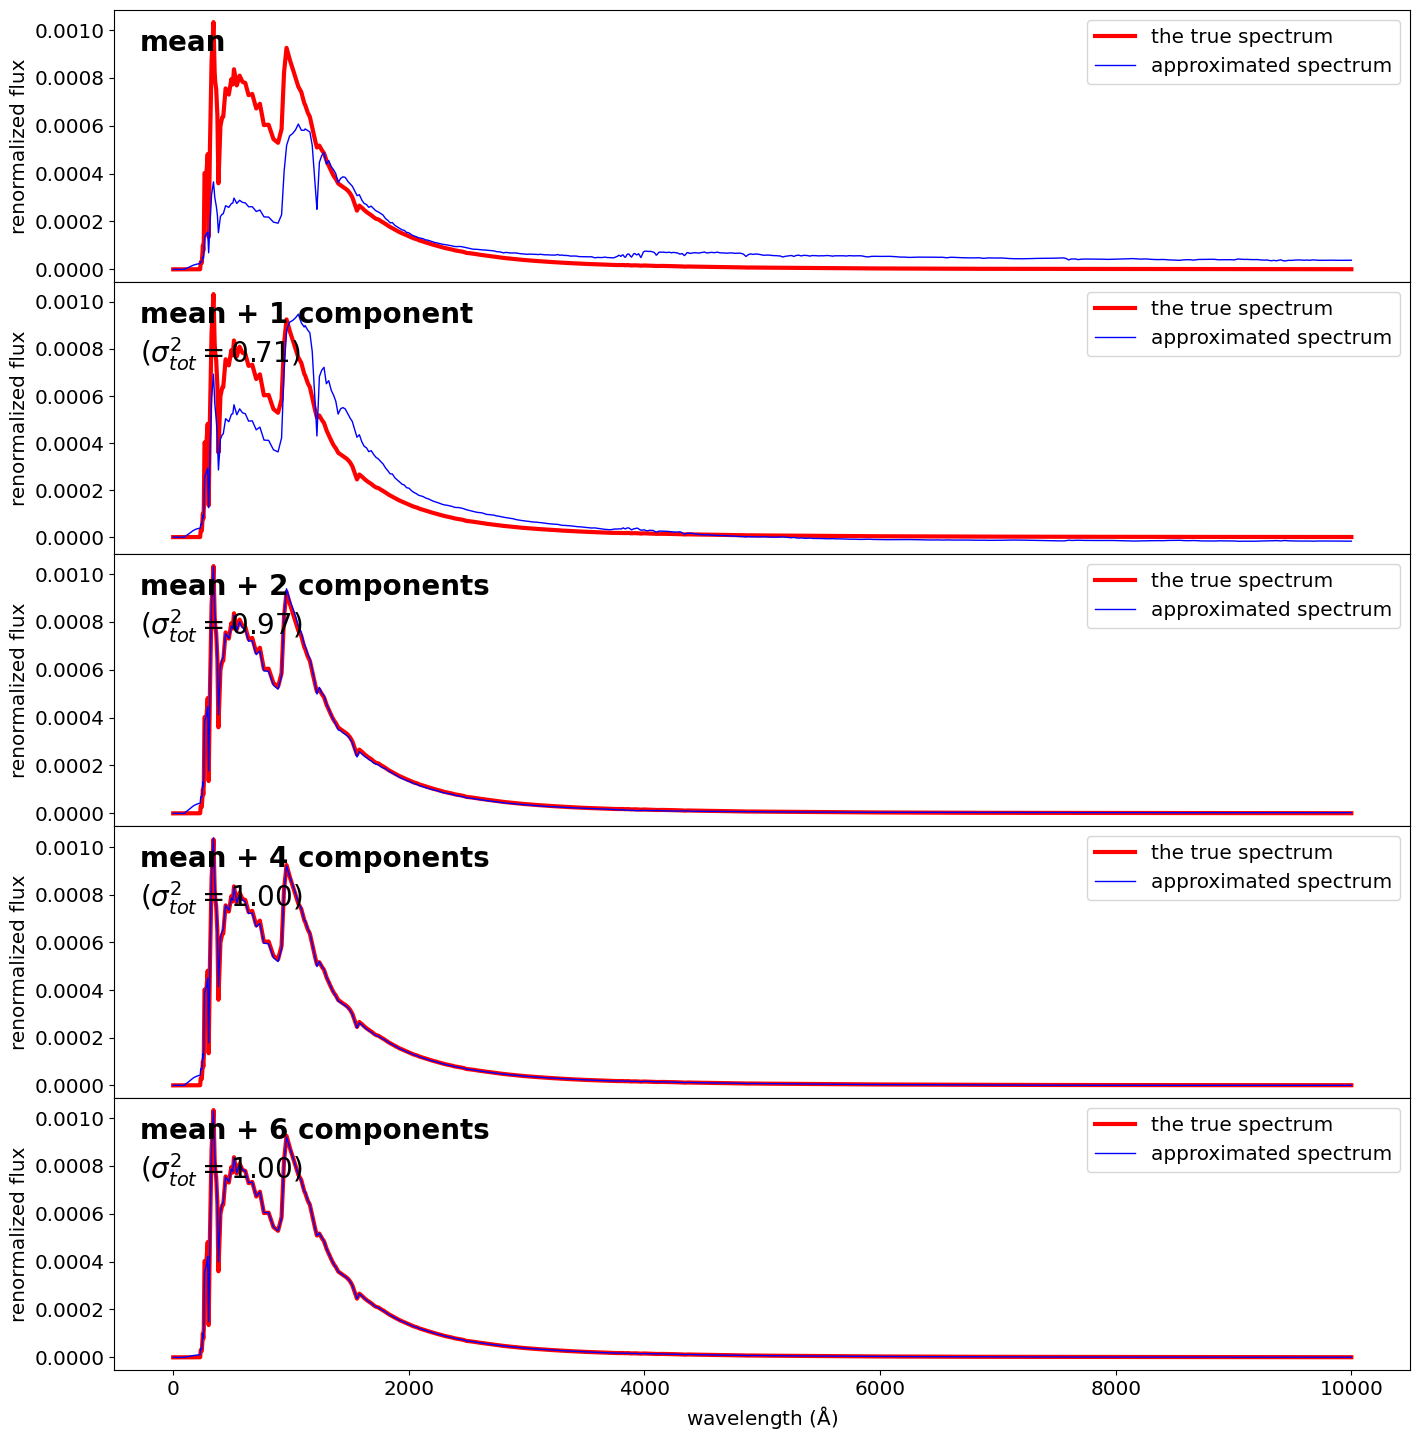

In [23]:
#------------------------------------------------------------
# Find the coefficients of a particular spectrum
idx=0
the_spec = spec[idx,:]
# computation of the coefficients 
coeff = np.dot(evecs, the_spec - spec_mean)
print("coeff",coeff)
# similar to comp = pca.transform(spec)
print("pca_coeffs = ",pca_coeffs[idx,:])

#------------------------------------------------------------
# Plot the sequence of reconstructions
fig = plt.figure(figsize=(16, 16))
fig.subplots_adjust(hspace=0, top=0.95, bottom=0.1, left=0.12, right=0.93)

for i, n in enumerate([0, 1 , 2, 4, 6 ]):
    ax = fig.add_subplot(511 + i)
    ax.plot(wavelengths, the_spec, '-', color='red',lw=3,label="the true spectrum")
    ax.plot(wavelengths, spec_mean + np.dot(coeff[:n], evecs[:n]), '-b',lw=1,label="approximated spectrum")

    if i < 3:
        ax.xaxis.set_major_formatter(plt.NullFormatter())

    #ax.set_ylim(-2, 21)
    ax.set_ylabel('renormalized flux')

    if n == 0:
        text = "mean"
    elif n == 1:
        text = "mean + 1 component\n"
        text += r"$(\sigma^2_{tot} = %.2f)$" % evals_cs[n - 1]
    else:
        text = "mean + %i components\n" % n
        text += r"$(\sigma^2_{tot} = %.2f)$" % evals_cs[n - 1]

    ax.text(0.02, 0.93, text, ha='left', va='top', transform=ax.transAxes,fontsize=20,fontweight="bold")
    ax.legend()

fig.axes[-1].set_xlabel(r'${\rm wavelength\ (\AA)}$')
plt.show()

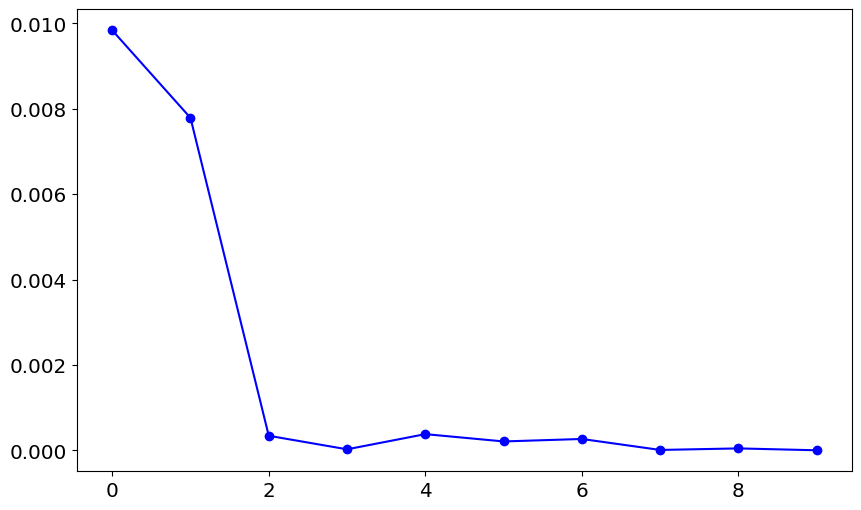

In [24]:
#plt.step(np.arange(len(coeff)),coeff)
plt.plot(range(len(coeff)),np.abs(coeff),'ob-')

### Eigenvalues

The top panel shows the decrease in eigenvalue as a function of the number of eigenvectors, with a break in the distribution at ten eigenvectors. The lower panel shows the cumulative sum of eigenvalues normalized to unity. 

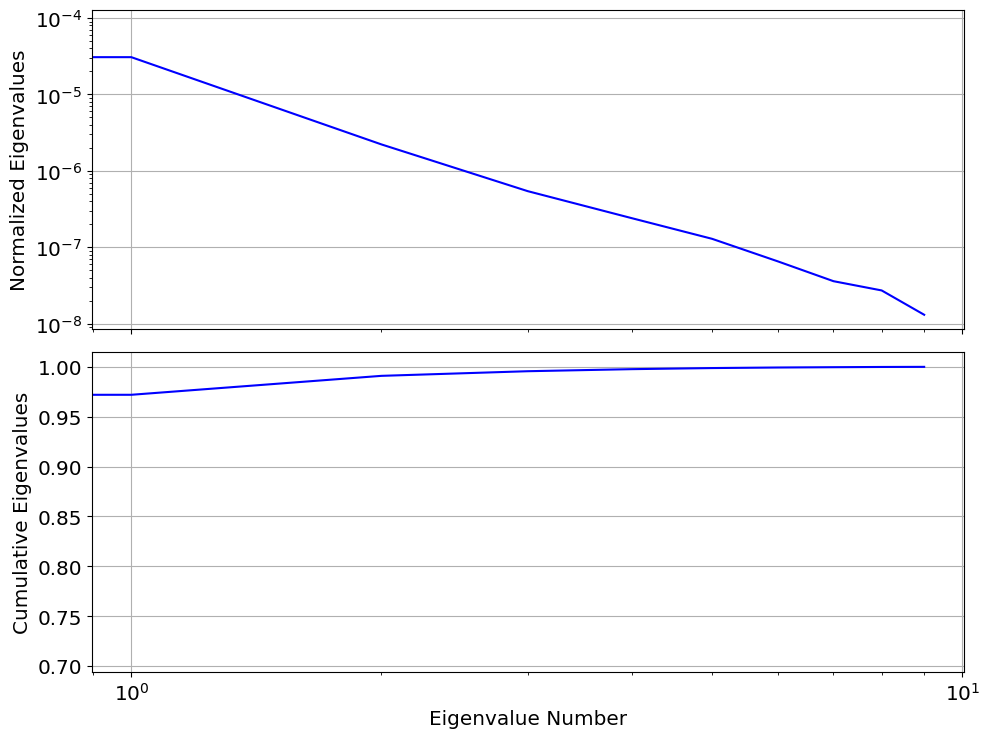

In [25]:
fig = plt.figure(figsize=(10, 7.5))
fig.subplots_adjust(hspace=0.05, bottom=0.12)

ax = fig.add_subplot(211, xscale='log', yscale='log')
ax.grid()
ax.plot(evals, c='b')
ax.set_ylabel('Normalized Eigenvalues')
ax.xaxis.set_major_formatter(plt.NullFormatter())
#ax.set_ylim(5E-4, 100)

ax = fig.add_subplot(212, xscale='log')
ax.grid()
ax.semilogx(evals_cs, color='b')
ax.set_xlabel('Eigenvalue Number')
ax.set_ylabel('Cumulative Eigenvalues')
#ax.set_ylim(0.65, 1.00)
plt.tight_layout()
plt.show()


# Compute for all coefficients

### PCA Reconstruction of a spectrum

Reconstruction of spectrum, ${x}(k)$, from the
eigenvectors, ${e}_i(k)$ 

$$  {x}_i(k) = {\mu}(k) + \sum_j^R \theta_{ij} {e}_j(k),$$

Truncating this expansion (i.e., $r<R$)

$$
{x}_i(k) = {\mu}(k) + \sum_i^{r<R} \theta_i {e}_i(k),
$$

- eigenvectors ordered by their associated eigenvalues 
- eigenvalues reflect variance  within each eigenvector (sum of the eigenvalues is total variance of the system).
- project a each spectrum onto these first few eigenspectra is a compression of the data 

This is the sense in which PCA gives for dimensionality reduction.

In [26]:
evecs = pca.components_

In [27]:
#------------------------------------------------------------
# Find the coefficients of a particular spectrum
all_coeff = []
for idx in range(NSED):
    the_spec = spec[idx,:]
    coeff = np.dot(evecs, the_spec - spec_mean)
    all_coeff.append(coeff)
all_coeff=np.vstack(all_coeff)

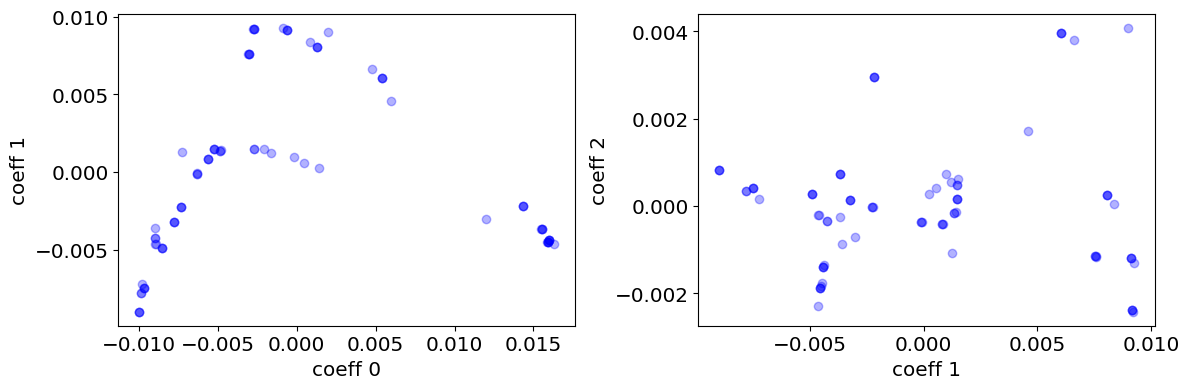

In [28]:
fig=plt.figure(figsize=(12,4))
ax=fig.add_subplot(1,2,1)
ax.scatter(all_coeff[:,0],all_coeff[:,1],c='b',alpha=0.3)
ax.set_xlabel("coeff 0")
ax.set_ylabel("coeff 1")  
ax=fig.add_subplot(1,2,2)
ax.scatter(all_coeff[:,1],all_coeff[:,2],c='b',alpha=0.3)
ax.set_xlabel("coeff 1")
ax.set_ylabel("coeff 2")
plt.tight_layout()

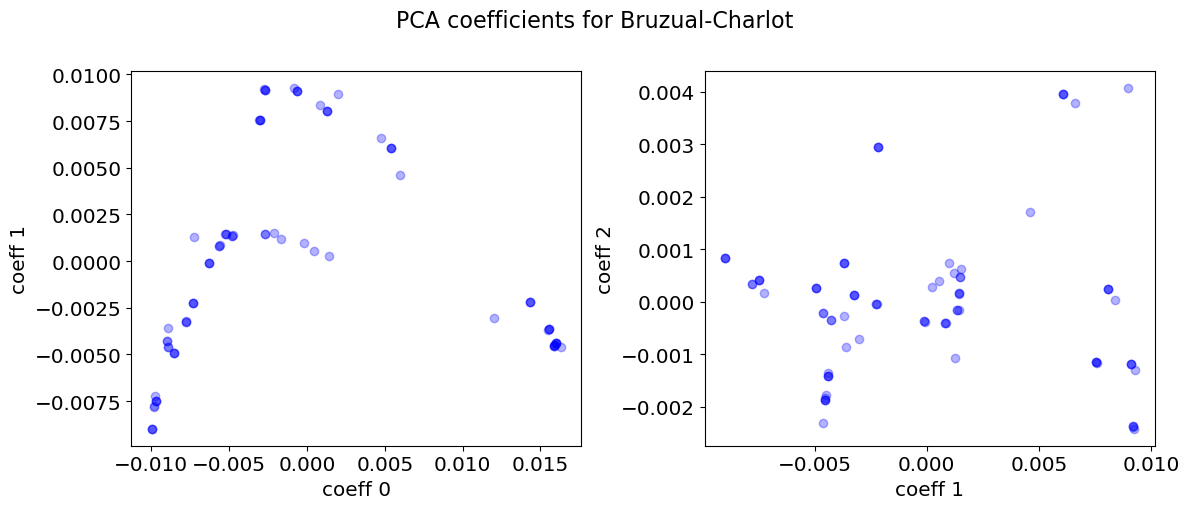

In [39]:
fig=plt.figure(figsize=(12,5))
ax=fig.add_subplot(1,2,1)
ax.scatter(all_coeff[:,0],all_coeff[:,1],c='b',alpha=0.3)
ax.set_xlabel("coeff 0")
ax.set_ylabel("coeff 1")  
ax=fig.add_subplot(1,2,2)
ax.scatter(all_coeff[:,1],all_coeff[:,2],c='b',alpha=0.3)
ax.set_xlabel("coeff 1")
ax.set_ylabel("coeff 2")
plt.suptitle("PCA coefficients for Bruzual-Charlot",y=1.01,size=16)
plt.tight_layout()
plt.show()

In [30]:
clim = (1.5, 6.5)
#cmap = discretize_cmap(plt.cm.jet, 5)
cmap = plt.cm.jet
cdict = ['unknown', 'star', 'absorption galaxy',
         'galaxy', 'emission galaxy',
         'narrow-line QSO', 'broad-line QSO']
cticks = [2, 3, 4, 5, 6]
formatter = plt.FuncFormatter(lambda t, *args: cdict[int(np.round(t))])
xlim = (-0.0075, .0075)

In [31]:
c='blue'
coeffs=all_coeff

/var/folders/m7/6pm3rhtj0c71ls7jj9mn1g740000gp/T/ipykernel_43227/834683659.py:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  im1 = ax1.scatter(coeffs[:, 0], coeffs[:, 1] ,**scatter_kwargs)
/var/folders/m7/6pm3rhtj0c71ls7jj9mn1g740000gp/T/ipykernel_43227/834683659.py:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  im2 = ax2.scatter(coeffs[:, 0], coeffs[:, 2], **scatter_kwargs)
/var/folders/m7/6pm3rhtj0c71ls7jj9mn1g740000gp/T/ipykernel_43227/834683659.py:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  im3 = ax3.scatter(coeffs[:, 1], coeffs[:, 2], **scatter_kwargs)


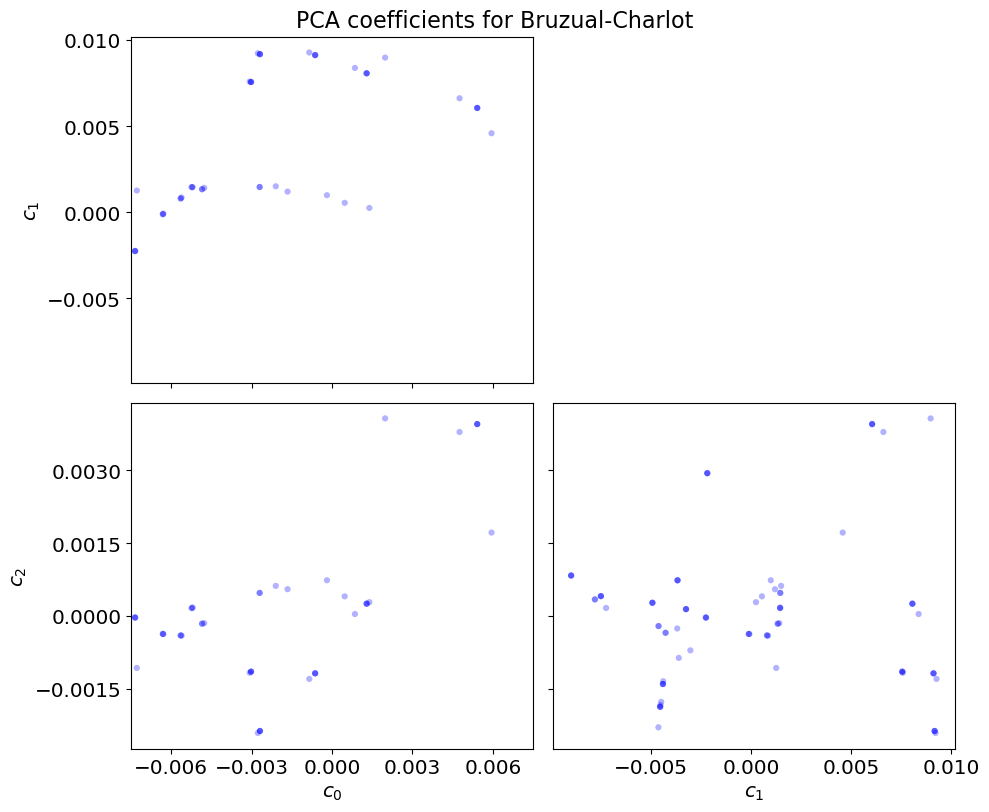

In [32]:
#----------------------------------------------------------------------
# Plot the results (astroml inspired):

fig = plt.figure(figsize=(10, 8))
fig.subplots_adjust(hspace=0.05, wspace=0.05)

# axes for colorbar
#cax = plt.axes([0.525, 0.525, 0.02, 0.35])

# Create scatter-plots
scatter_kwargs = dict(marker='o',s=20, lw=0, edgecolors='none', c=c, cmap=cmap,alpha=0.3)

ax1 = plt.subplot(221)
im1 = ax1.scatter(coeffs[:, 0], coeffs[:, 1] ,**scatter_kwargs)
im1.set_clim(clim)
ax1.set_ylabel('$c_1$')

ax2 = plt.subplot(223)
im2 = ax2.scatter(coeffs[:, 0], coeffs[:, 2], **scatter_kwargs)
im2.set_clim(clim)
ax2.set_xlabel('$c_0$')
ax2.set_ylabel('$c_2$')

ax3 = plt.subplot(224)
im3 = ax3.scatter(coeffs[:, 1], coeffs[:, 2], **scatter_kwargs)
im3.set_clim(clim)
ax3.set_xlabel('$c_1$')

#fig.colorbar(im3, ax=ax3, cax=cax,ticks=cticks,format=formatter)

ax1.xaxis.set_major_formatter(plt.NullFormatter())
ax3.yaxis.set_major_formatter(plt.NullFormatter())

ax1.set_xlim(xlim)
ax2.set_xlim(xlim)

for ax in (ax1, ax2, ax3):
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))

plt.tight_layout()
plt.suptitle("PCA coefficients for Bruzual-Charlot",y=1.01,size=16)
plt.show()


In [33]:
all_coeff

array([[-9.84099542e-03, -7.78937018e-03,  3.41753225e-04,
        -2.47546963e-05,  3.80194038e-04, -2.09013986e-04,
        -2.66832547e-04, -9.73239354e-06, -4.58764793e-05,
         2.03445522e-06],
       [-2.68898016e-03,  9.17331501e-03, -2.37537717e-03,
         6.54914076e-04,  3.45033078e-04,  3.67030690e-04,
        -3.46193086e-04,  4.05678375e-05,  2.73915897e-04,
        -1.27587520e-05],
       [ 5.41853197e-03,  6.05351862e-03,  3.95704976e-03,
        -1.20105004e-03,  5.55820136e-04,  1.52005574e-04,
         9.18029574e-06,  6.89659243e-05,  6.52697012e-05,
        -1.51418251e-05],
       [ 1.55647970e-02, -3.66574108e-03,  7.33587494e-04,
         1.50128295e-03, -2.32859930e-04, -1.53871858e-04,
        -4.35247718e-06,  4.21161207e-04, -3.83058621e-05,
        -3.17987145e-04],
       [ 1.58933917e-02, -4.53349373e-03, -1.87659955e-03,
        -1.03003318e-03,  1.01989745e-04,  8.89330259e-05,
         3.07201392e-05, -2.98716186e-04,  1.62270639e-05,
         2.

In [34]:
pca_coeffs 

array([[-9.84099542e-03, -7.78937018e-03,  3.41753225e-04,
        -2.47546963e-05,  3.80194038e-04, -2.09013986e-04,
        -2.66832547e-04, -9.73239354e-06, -4.58764793e-05,
         2.03445522e-06],
       [-2.68898016e-03,  9.17331501e-03, -2.37537717e-03,
         6.54914076e-04,  3.45033078e-04,  3.67030690e-04,
        -3.46193086e-04,  4.05678375e-05,  2.73915897e-04,
        -1.27587520e-05],
       [ 5.41853197e-03,  6.05351862e-03,  3.95704976e-03,
        -1.20105004e-03,  5.55820136e-04,  1.52005574e-04,
         9.18029574e-06,  6.89659243e-05,  6.52697012e-05,
        -1.51418251e-05],
       [ 1.55647970e-02, -3.66574108e-03,  7.33587494e-04,
         1.50128295e-03, -2.32859930e-04, -1.53871858e-04,
        -4.35247718e-06,  4.21161207e-04, -3.83058621e-05,
        -3.17987145e-04],
       [ 1.58933917e-02, -4.53349373e-03, -1.87659955e-03,
        -1.03003318e-03,  1.01989745e-04,  8.89330259e-05,
         3.07201392e-05, -2.98716186e-04,  1.62270639e-05,
         2.

## Save a coefficient in a fits file

In [35]:
filename_out = "pcamethod1_BruzualCharlot_eigenvectorandcoeff.fits"
hdr = fits.Header()
hdr["COMMENT"] = "PCA method 1 spectra coefficients"
hdr2 = fits.Header()
hdr2["COMMENT"] = "PCA method 1 Eigen Vectors"

In [36]:
primary_hdu = fits.PrimaryHDU(data_in,hdr_in)
image_hdu = fits.ImageHDU(all_coeff,hdr)
image_hdu2 = fits.ImageHDU(pca.components_,hdr2)

In [37]:
hdul = fits.HDUList([primary_hdu, image_hdu, image_hdu2])

In [38]:
hdul.writeto(filename_out,overwrite=True)